#  PROJECT 3: WEB APIs and NLP PART 2

#### Book 3: Modelling

In [64]:
# Imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
posts = pd.read_csv('data/clean_pp_posts.csv')

In [3]:
comments = pd.read_csv('data/clean_pp_comments.csv')

In [4]:
posts.shape

(21609, 10)

In [5]:
comments.shape

(38424, 8)

### 1.0 Modeling

##### Train_Test Split

In [7]:
# Redefine X and y and resplit data
X = posts['lem_tokens']
y = posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

##### Baseline Score

In [29]:
baseline = y_train.value_counts(normalize=True)

In [30]:
baseline

1    0.524106
0    0.475894
Name: subreddit, dtype: float64

### 2.1 Logistic Regression

In [65]:
# Set up pipeline
pipe_lr_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=5000))
])

# Set up pipeline params
pipe_lr_c_params = {
    'cvec__max_features': [200, 500],
}

In [66]:
# Set up a gridsearch
gs_lr_c = GridSearchCV(pipe_lr_c, pipe_lr_c_params, cv=5, verbose=1)

# Fit the gridsearch
gs_lr_c.fit(X_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [67]:
gs_lr_c.best_score_

0.889625640511837

In [68]:
gs_lr_c.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=500, ngram_range=(1, 2),
                                 stop_words='english')),
                ('lr', LogisticRegression(max_iter=5000))])

In [69]:
coefs= gs_lr_c.best_estimator_.named_steps.lr.coef_


In [77]:
print(f'Training Score: {gs_lr_c.score(X_train, y_train)}')
print(f'Testing Score: {gs_lr_c.score(X_test, y_test)}')

Training Score: 0.9044757563199337
Testing Score: 0.8834665544804375


### 2.2 Random Forest

In [12]:
# Set up pipeline
pipe_rf_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', max_features=500, ngram_range=(1,2))),
    ('rf', RandomForestClassifier())
])

# Set up pipeline parameters
pipe_rf_c_params = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 5, 6], 
    'rf__max_features': ['auto', 'log2'],
    'rf__min_samples_split': [2, 50]
}

In [13]:
# Set up a gridsearch
gs_rf_c = GridSearchCV(pipe_rf_c, pipe_rf_c_params, cv=5, verbose=1)

# Fit the gridsearch
gs_rf_c.fit(X_train, y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [80]:
gs_rf_c.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=500, ngram_range=(1, 2),
                                 stop_words='english')),
                ('rf',
                 RandomForestClassifier(max_features='log2',
                                        min_samples_split=50,
                                        n_estimators=200))])

In [14]:
gs_rf_c.best_score_

0.887967442437428

In [78]:
print(f'Training Score: {gs_rf_c.score(X_train, y_train)}')
print(f'Testing Score: {gs_rf_c.score(X_test, y_test)}')

Training Score: 0.937007874015748
Testing Score: 0.8823446921890338


### 2.3 KNN

In [15]:
# Set up pipeline
pipe_knn_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', max_features=200, ngram_range=(1,2))),
    ('knn', KNeighborsClassifier())
])


# Set up pipeline params
pipe_knn_c_params = {
    'cvec__max_features': [200, 500],
    'knn__n_neighbors':[5, 15, 25, 35, 45],
    'knn__p': [1, 2]
}

In [16]:
# Set up a gridsearch
gs_knn_c = GridSearchCV(pipe_knn_c, pipe_knn_c_params, cv=5, verbose=1)

# Fit the gridsearch
gs_knn_c.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [17]:
gs_knn_c.best_score_

0.842104910352198

In [79]:
print(f'Training Score: {gs_knn_c.score(X_train, y_train)}')
print(f'Testing Score: {gs_knn_c.score(X_test, y_test)}')

Training Score: 0.846525763226965
Testing Score: 0.8259711120459964


### 2.0

### Comparing Models

In [45]:
# Generate a dataframe of model & accuracy score
list_of_models = [gs_lr_c, 
                  gs_knn_c, 
                  gs_rf_c,
                  ]

# Create an empty list for each model's dictionary
models = []

for mod in list_of_models:
    # mod.best_score_
    model = {}
    model['type'] = str(list(mod.estimator.named_steps.keys()))
    model['accuracy'] = mod.best_score_
    models.append(model)

# Append baseline for comparison
baseline = {}
baseline['type'] = 'baseline'
baseline['accuracy'] = y_train.value_counts(normalize=True)[1]
models.append(baseline)

models_df = pd.DataFrame(models)
models_df.head()

,type,accuracy
0,"['cvec', 'lr']",0.889626
1,"['cvec', 'knn']",0.842105
2,"['cvec', 'rf']",0.887967
3,baseline,0.524106


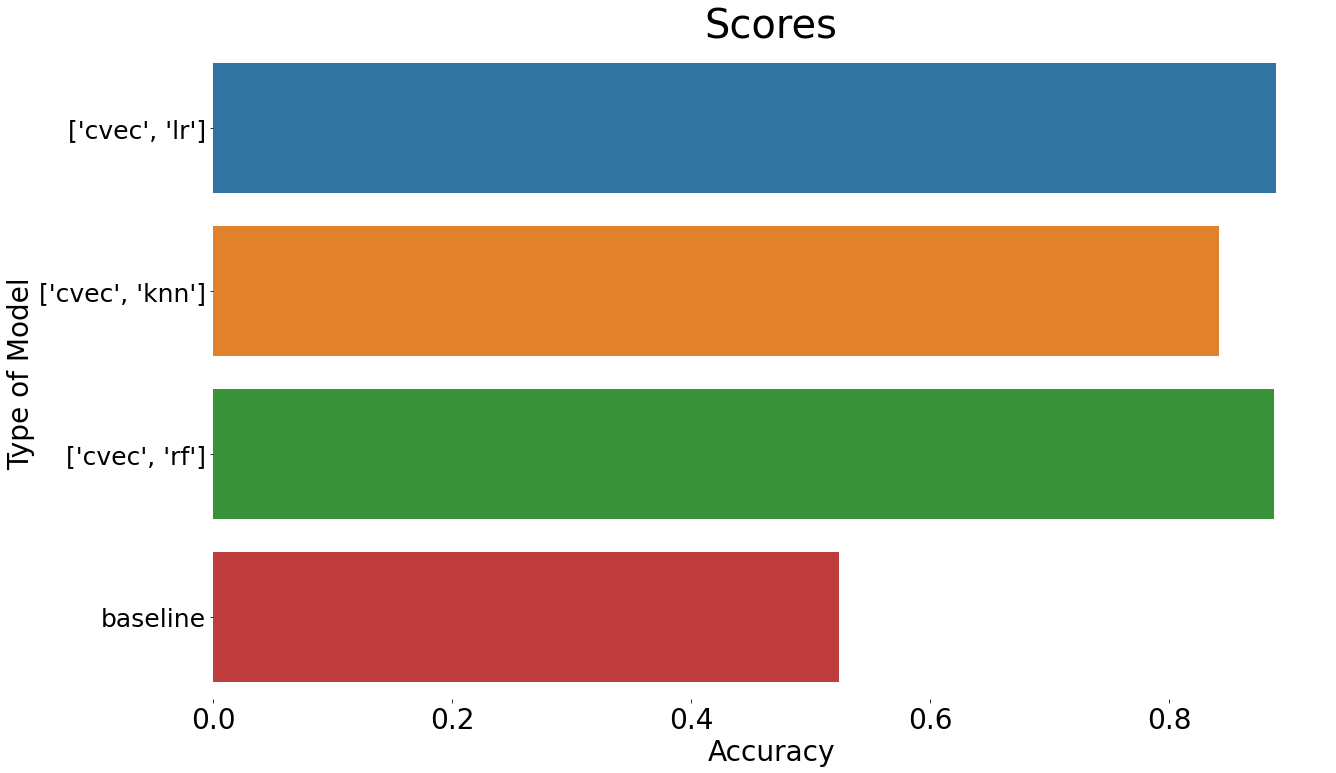

In [50]:
plt.figure(figsize=(20,12))
sns.barplot(data=models_df, x='accuracy', y='type')
plt.xlabel('Accuracy', size=28)
plt.ylabel('Type of Model', size=28)
plt.yticks(size=25)
plt.xticks(size=28)
plt.title('Scores', size=40)
sns.despine(left=True, bottom=True);